#  Time Series Analysis and prediction of Stock Market data using                                                           Deep Learning Techniques

In [1]:

import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import warnings
warnings.filterwarnings('ignore')


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### -->Preprocessing of the data

In [2]:
df = pd.read_csv("ge.us.txt")

### chech if the data is stationary or not using Augmented Dickey Fuller Test

In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
def adtest(dataset):
    dftest = adfuller(dataset, autolag="AIC")
    print("1. ADF : ", dftest[0])
    print("2. P-VALUES : ", dftest[1])
    print("3. NUM OF LAGS : ", dftest[2])
    print("4. NUM OF OBSERVATIONS USED FOR THE ADF REGRESSION AND CRITICAL VALUES CALCULATION : ", dftest[3])
    print("5. CRITICAL VALUES : ")
    for key, val in dftest[4].items():
        print("\t", key, ": ",val)

In [5]:
adtest(df['Volume'])

1. ADF :  -5.291694750628635
2. P-VALUES :  5.696778320417007e-06
3. NUM OF LAGS :  42
4. NUM OF OBSERVATIONS USED FOR THE ADF REGRESSION AND CRITICAL VALUES CALCULATION :  14015
5. CRITICAL VALUES : 
	 1% :  -3.430816678424626
	 5% :  -2.8617462506106843
	 10% :  -2.5668797824065726


In [6]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [7]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


In [8]:
print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

            0.00          0.05          0.50          0.95          0.99  \
Open     0.45902  6.683000e-01  3.880900e+00  3.083500e+01  4.156000e+01   
High     0.46690  6.683000e-01  3.912700e+00  3.110900e+01  4.220687e+01   
Low      0.45114  6.602000e-01  3.824300e+00  3.052325e+01  4.090301e+01   
Close    0.45902  6.683000e-01  3.884800e+00  3.079520e+01  4.161400e+01   
Volume   0.00000  1.776671e+06  1.597520e+07  7.796374e+07  1.590421e+08   
OpenInt  0.00000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                 1.00  
Open     4.775100e+01  
High     4.845900e+01  
Low      4.759600e+01  
Close    4.805600e+01  
Volume   9.345354e+08  
OpenInt  0.000000e+00  


In [9]:
print(df.isnull().sum())

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


In [10]:
print(df.shape)

(14058, 7)


In [11]:
print(df.dtypes)


Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object


In [12]:
df["Date"]=pd.to_datetime(df["Date"])

In [13]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [14]:
Stock_df= df[["Date","Close"]]

In [15]:
Stock_df.head()

,Date,Close
0,1962-01-02,0.6201
1,1962-01-03,0.6201
2,1962-01-04,0.6122
3,1962-01-05,0.5957
4,1962-01-08,0.5957


In [16]:
print("Min. Date:",Stock_df["Date"].min())
print("Max. Date:",Stock_df["Date"].max())

Min. Date: 1962-01-02 00:00:00
Max. Date: 2017-11-10 00:00:00


In [17]:
Stock_df.index=Stock_df["Date"]

In [18]:
Stock_df

,Date,Close
Date,,
1962-01-02,1962-01-02,0.6201
1962-01-03,1962-01-03,0.6201
1962-01-04,1962-01-04,0.6122
1962-01-05,1962-01-05,0.5957
1962-01-08,1962-01-08,0.5957
...,...,...
2017-11-06,2017-11-06,20.1300
2017-11-07,2017-11-07,20.2100
2017-11-08,2017-11-08,20.1200


In [19]:
Stock_df.drop("Date",axis=1,inplace=True)

In [20]:
Stock_df

,Close
Date,
1962-01-02,0.6201
1962-01-03,0.6201
1962-01-04,0.6122
1962-01-05,0.5957
1962-01-08,0.5957
...,...
2017-11-06,20.1300
2017-11-07,20.2100
2017-11-08,20.1200


In [21]:
result_df=Stock_df.copy()

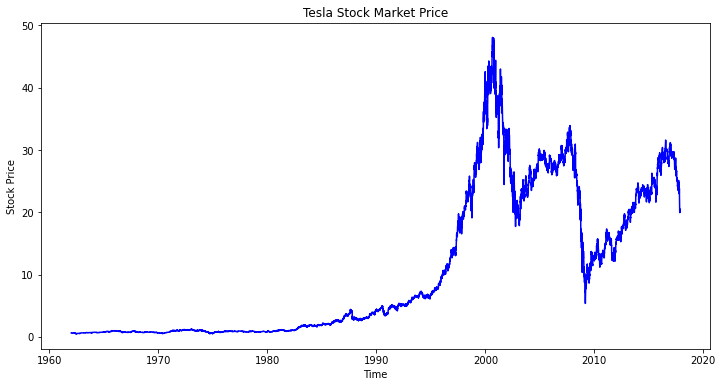

In [22]:
plt.figure(figsize=(12,6))
plt.plot(Stock_df["Close"],color="blue")
plt.ylabel("Stock Price")
plt.title("Tesla Stock Market Price")
plt.xlabel("Time")
plt.show()

In [23]:
Stock_df=Stock_df.values

In [24]:
Stock_df[0:5]

array([[0.6201],
       [0.6201],
       [0.6122],
       [0.5957],
       [0.5957]])

In [25]:
Stock_df=Stock_df.astype("float32")

### ->Training and testing the model

In [26]:
pos=int(round(len(Stock_df)*(1-0.20)))
train=Stock_df[:pos]
test=Stock_df[pos:]

In [27]:
print(pos, train.shape, test.shape)

11246 (11246, 1) (2812, 1)


In [28]:
print(train.shape,test.shape)

(11246, 1) (2812, 1)


In [29]:
scaler_train=MinMaxScaler(feature_range=(0,1))

In [30]:
train=scaler_train.fit_transform(train)

In [31]:
scaler_test=MinMaxScaler(feature_range=(0,1))

In [32]:
test=scaler_test.fit_transform(test)

In [33]:
train[0:5]

array([[0.00338425],
       [0.00338425],
       [0.00321827],
       [0.00287161],
       [0.00287161]], dtype=float32)

In [34]:
test[0:5]

array([[0.7946966],
       [0.7930853],
       [0.7950119],
       [0.7955373],
       [0.7950119]], dtype=float32)

In [35]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)

In [36]:
lookback=30

In [37]:
X_train,y_train=create_features(train,lookback)

In [38]:
X_test,y_test=create_features(test,lookback)

In [39]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(11216, 30) (11216,) (2782, 30) (2782,)


In [40]:
X_train[0:5]

array([[0.00338425, 0.00338425, 0.00321827, 0.00287161, 0.00287161,
        0.00287161, 0.00287161, 0.00287161, 0.00270563, 0.00287161,
        0.00303969, 0.00270563, 0.00287161, 0.00303969, 0.00303969,
        0.00270563, 0.00303969, 0.00287161, 0.00287161, 0.00287161,
        0.00303969, 0.00354392, 0.00338425, 0.00338425, 0.00321827,
        0.00338425, 0.00354392, 0.00354392, 0.00354392, 0.00354392],
       [0.00338425, 0.00321827, 0.00287161, 0.00287161, 0.00287161,
        0.00287161, 0.00287161, 0.00270563, 0.00287161, 0.00303969,
        0.00270563, 0.00287161, 0.00303969, 0.00303969, 0.00270563,
        0.00303969, 0.00287161, 0.00287161, 0.00287161, 0.00303969,
        0.00354392, 0.00338425, 0.00338425, 0.00321827, 0.00338425,
        0.00354392, 0.00354392, 0.00354392, 0.00354392, 0.0037225 ],
       [0.00321827, 0.00287161, 0.00287161, 0.00287161, 0.00287161,
        0.00287161, 0.00270563, 0.00287161, 0.00303969, 0.00270563,
        0.00287161, 0.00303969, 0.00303969, 0.

In [41]:
y_test[0:5]

array([0.8164494, 0.815889 , 0.8051702, 0.80489  , 0.8023329],
      dtype=float32)

In [42]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))

In [43]:
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [44]:
y_train=y_train.reshape(-1,1)

In [45]:
y_test=y_test.reshape(-1,1)

In [46]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(11216, 1, 30) (11216, 1) (2782, 1, 30) (2782, 1)


In [47]:
def ANN(m):
    from keras.models import Sequential
    from keras.layers import Dense
   
    model.add(Dense(11,activation='relu',input_dim=30))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(X_train,y_train,epochs=3)

In [48]:
from lib.utils import *
ac=[]

In [49]:
model=ANN(X_train)

In [50]:
model.compile(loss="mean_squared_error",optimizer="adam")


In [51]:
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]

In [52]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=200,
                    batch_size=30,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)
ac.append(accuracy_score(model,y_test,sample_weight=0.2)*100)

Epoch 1/200
364/374 [============================>.] - ETA: 0s - loss: 0.0011   
Epoch 1: val_loss improved from inf to 0.00327, saving model to mymodel.h5
374/374 [==============================] - 4s 5ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 2/200
367/374 [============================>.] - ETA: 0s - loss: 0.0015 
Epoch 2: val_loss improved from 0.00327 to 0.00186, saving model to mymodel.h5
374/374 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 3/200
361/374 [===========================>..] - ETA: 0s - loss: 0.0011    
Epoch 3: val_loss did not improve from 0.00186
374/374 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 4/200
374/374 [==============================] - ETA: 0s - loss: 0.0011    
Epoch 4: val_loss did not improve from 0.00186
374/374 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 5/200
374/374 [==============================] - ETA: 0s - loss: 0

In [53]:
loss=model.evaluate(X_test,y_test,batch_size=30)

93/93 [==============================] - 0s 2ms/step - loss: 0.0029


In [54]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

87/87 [==============================] - 0s 3ms/step


In [55]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [56]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [57]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))

In [58]:
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))

In [59]:
train_prediction_data=result_df[lookback:pos]

In [60]:
train_prediction_data["Predicted"]=train_predict

In [61]:
test_prediction_data=result_df[pos+lookback:]

In [62]:
test_prediction_data["Predicted"]=test_predict

In [63]:
print("Daily predcition")
test_prediction_data.head()

Daily predcition


,Close,Predicted
Date,,
2006-10-25,28.670,26.877455
2006-10-26,28.654,26.875175
2006-10-27,28.348,26.869520
2006-10-30,28.340,26.829227
2006-10-31,28.267,26.799921


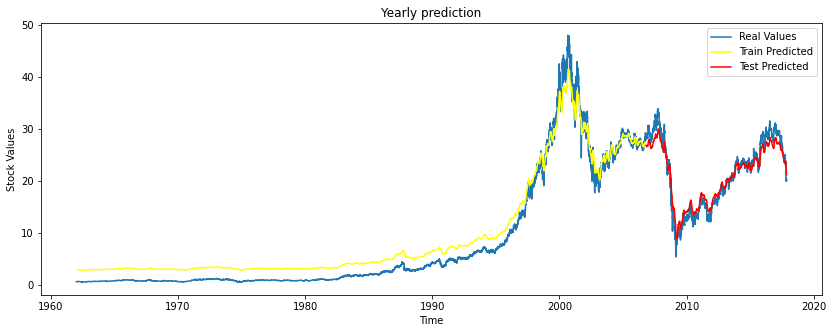

In [64]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label="Real Values",)
plt.plot(train_prediction_data["Predicted"],color="yellow",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.title("Yearly prediction")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()

In [65]:
###pip install lib-0.1.0-py3-none-any.whl


In [68]:
from sklearn import tree
from sklearn import preprocessing
lab = preprocessing.LabelEncoder()

y_transformed = lab.fit_transform(y_train)

model=tree.DecisionTreeClassifier()
model.fit(X_train.reshape(11216,-1),y_transformed)
y_pred=model.predict(X_test.reshape(2782,-1))
ac.append(accuracy_score(y_pred,y_test,sample_weight=0.8)*100)

the accuracy of Decision Tree is 94.19999999999999 and ANN is 96.00999999999999


(50.0, 100.0)

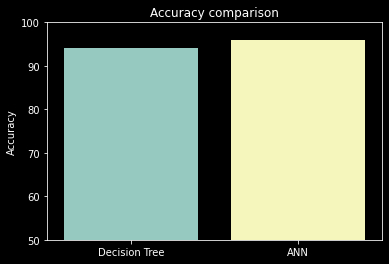

In [69]:
import numpy as np
import seaborn as sns
import matplotlib as plt


plt.style.use('dark_background')
x=['Decision Tree','ANN']
ac.reverse()
ax=sns.barplot(x,ac)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)